## Hyperparameter tuning via Optuna

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import pyarrow.parquet as pq
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

sys.path.append("../..")

from MLP_utils.exceptions import ModelNameError
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

In [2]:
# Parameters
SHUFFLE_DATA = False
CELL_TYPE = "SHSY5Y"
CONTROL_NAME = "DMSO_0.100_DMSO_0.025"
TREATMENT_NAME = "Thapsigargin_10.000_DMSO_0.025"
MODEL_NAME = "DMSO_0.025_vs_Thapsigargin_10"

In [3]:
data = Path("../../MLP_utils/binary_config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

# overwrite params via command line arguments from papermill
params.CELL_TYPE = CELL_TYPE
params.MODEL_NAME = MODEL_NAME
params.CONTROL_NAME = CONTROL_NAME
params.TREATMENT_NAME = TREATMENT_NAME
params.MODEL_NAME = MODEL_NAME

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = Path(f"../../../data/{params.CELL_TYPE}_preprocessed_sc_norm.parquet")

df = pq.read_table(file_path).to_pandas()

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [5]:
# filter the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column to only include the treatment and control via loc
df = df.loc[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [params.TREATMENT_NAME, params.CONTROL_NAME]
    )
]

print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
df_stats(df)

if params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025' 'Thapsigargin_10.000_DMSO_0.025']
The dimensions of the data are: (48855, 1276)
Number of total missing values across all columns: 97710
Data Subset Is Off


In [6]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['I14' 'L14']
Wells to use for training, validation, and testing ['B14' 'C14' 'E14' 'B15' 'C15' 'E15' 'J14' 'I15' 'J15' 'L15']


In [7]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [8]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

#### Split Data - All Models can proceed through this point

In [9]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=1,
    params=params,
)

In [10]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [11]:
params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", params.IN_FEATURES)
if params.MODEL_TYPE == "Regression":
    params.OUT_FEATURES = 1
else:
    params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", params.OUT_FEATURES)

if params.OUT_FEATURES > 2:
    params.MODEL_TYPE = "Multi_Class"
elif params.OUT_FEATURES == 2:
    params.OUT_FEATURES = params.OUT_FEATURES - 1
    params.MODEL_TYPE = "Binary_Classification"
elif params.OUT_FEATURES == 1:
    params.MODEL_TYPE = "Regression"
else:
    pass
print(params.MODEL_TYPE)

Number of in features:  1251
Number of out features:  2
Binary_Classification


In [12]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=SHUFFLE_DATA
)

In [13]:
print(params.DEVICE)

cuda


In [14]:
# no accuracy function must be loss for regression
if params.MODEL_TYPE == "Regression":
    params.METRIC = "loss"
    pass


# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    params=params,
    metric=params.METRIC,
    return_info=False,
)


# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}")
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-08-03 18:58:28,708] A new study created in memory with name: no-name-e09588aa-bc4e-49b5-9c6d-7a5b6f5a050f
[I 2023-08-03 18:58:40,301] Trial 0 finished with value: 0.23735268482565883 and parameters: {'n_layers': 3, 'n_units_l0': 3, 'dropout_0': 0.2801094062312778, 'n_units_l1': 3, 'dropout_1': 0.25218953379747144, 'n_units_l2': 6, 'dropout_2': 0.1834432980081137, 'learning_rate': 0.07082238088540066, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.23735268482565883.
[I 2023-08-03 18:58:50,753] Trial 1 finished with value: 0.12812778062373398 and parameters: {'n_layers': 3, 'n_units_l0': 9, 'dropout_0': 0.2705409086730711, 'n_units_l1': 8, 'dropout_1': 0.21580575370582447, 'n_units_l2': 2, 'dropout_2': 0.2652183758229085, 'learning_rate': 0.00873054422158719, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.12812778062373398.
[I 2023-08-03 18:59:01,146] Trial 2 finished with value: 0.4447024640440941 and parameters: {'n_layers': 3, 'n_units_l0': 10, 'dropout_0': 0.31238

Validation Accuracy: 94.85939036381515
Validation Loss: 0.1263872863352299
Training Accuracy: 88.52716990410622
Training Loss: 0.247632417642709


(94.85939036381515, 0.1263872863352299, 88.52716990410622, 0.247632417642709)

In [15]:
# create graph directory for this model
graph_path = Path(
    f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/{params.CELL_TYPE}"
)
Path(graph_path).mkdir(parents=True, exist_ok=True)
fig = optuna.visualization.plot_optimization_history(study)

if SHUFFLE_DATA:
    graph_path = f"{graph_path}/plot_optimization_history_graph_shuffled_data"
elif not SHUFFLE_DATA:
    graph_path = f"{graph_path}/plot_optimization_history_graph"
else:
    raise ModelNameError
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [16]:
# create graph directory for this model
graph_path = Path(
    f"../../figures/{params.MODEL_TYPE}/{params.MODEL_NAME}/{params.CELL_TYPE}"
)
Path(graph_path).mkdir(parents=True, exist_ok=True)
fig = optuna.visualization.plot_intermediate_values(study)
if SHUFFLE_DATA:
    graph_path = f"{graph_path}/plot_intermediate_values_graph_shuffled_data"
elif not SHUFFLE_DATA:
    graph_path = f"{graph_path}/plot_intermediate_values_graph"
else:
    raise ModelNameError

fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [17]:
param_dict = extract_best_trial_params(
    study.best_params, params, model_name=params.MODEL_NAME
)

In [18]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    param_dict,
    params,
    params.MODEL_NAME,
)
# get training_metrics
if params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

RMSprop
Epoch 0: Validation loss decreased (inf --> 0.588100).  Saving model ...
	 Train_Loss: 0.6490 Train_Acc: 67.633 Val_Loss: 0.5881  BEST VAL Loss: 0.5881  Val_Acc: 75.737

Epoch 1: Validation loss decreased (0.588100 --> 0.525989).  Saving model ...
	 Train_Loss: 0.6128 Train_Acc: 76.088 Val_Loss: 0.5260  BEST VAL Loss: 0.5260  Val_Acc: 88.176

Epoch 2: Validation loss decreased (0.525989 --> 0.479756).  Saving model ...
	 Train_Loss: 0.5682 Train_Acc: 83.197 Val_Loss: 0.4798  BEST VAL Loss: 0.4798  Val_Acc: 90.069

Epoch 3: Validation loss decreased (0.479756 --> 0.441872).  Saving model ...
	 Train_Loss: 0.5359 Train_Acc: 84.347 Val_Loss: 0.4419  BEST VAL Loss: 0.4419  Val_Acc: 92.281

Epoch 4: Validation loss decreased (0.441872 --> 0.414310).  Saving model ...
	 Train_Loss: 0.5126 Train_Acc: 84.709 Val_Loss: 0.4143  BEST VAL Loss: 0.4143  Val_Acc: 92.429

Epoch 5: Validation loss decreased (0.414310 --> 0.391511).  Saving model ...
	 Train_Loss: 0.4933 Train_Acc: 85.047 Val_L

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/0.model_training/notebooks/../../MLP_utils/utils.py:959: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/0.model_training/notebooks/../../MLP_utils/utils.py:960: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



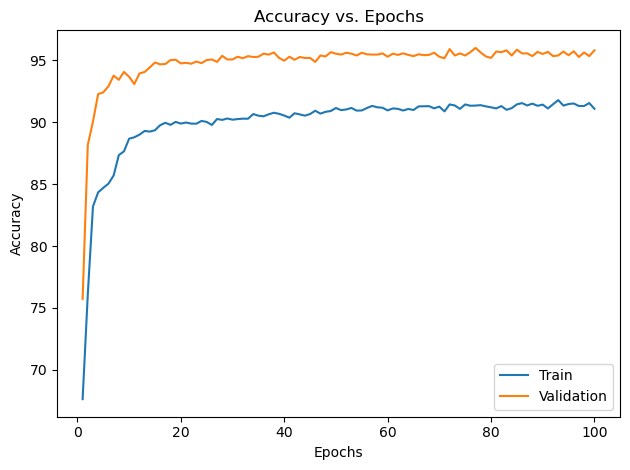

In [21]:
if params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=params.MODEL_NAME,
        shuffle=SHUFFLE_DATA,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/0.model_training/notebooks/../../MLP_utils/utils.py:959: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/0.model_training/notebooks/../../MLP_utils/utils.py:960: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



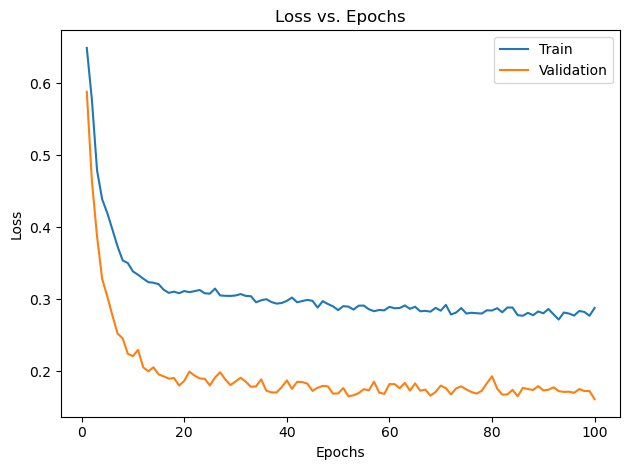

In [22]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=params.MODEL_NAME,
    shuffle=SHUFFLE_DATA,
)

In [23]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3081
           1       0.94      0.88      0.91       987

    accuracy                           0.96      4068
   macro avg       0.95      0.93      0.94      4068
weighted avg       0.96      0.96      0.96      4068



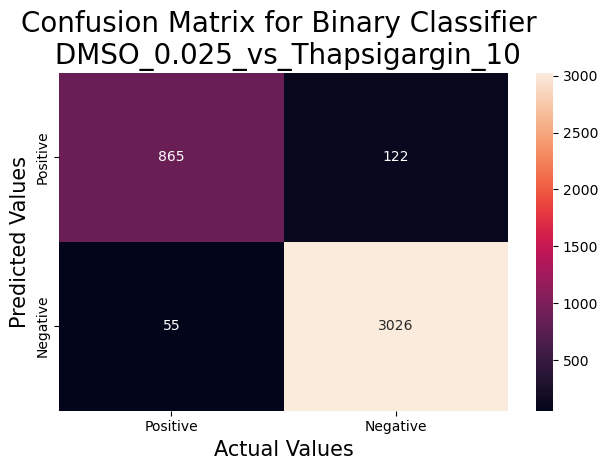

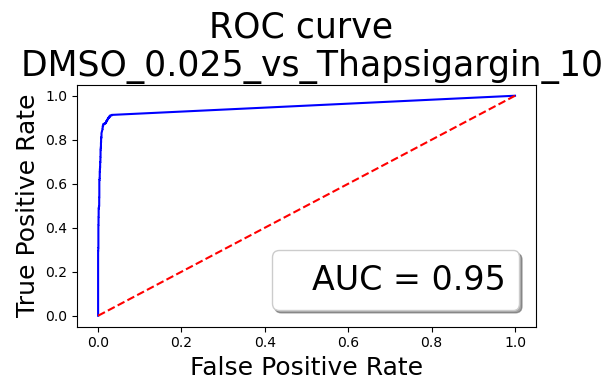

In [24]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
        title=params.MODEL_NAME,
        shuffle=SHUFFLE_DATA,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_testing",
        model_name=params.MODEL_NAME,
        title=params.MODEL_NAME,
        shuffle=SHUFFLE_DATA,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

#### look at the feature weights of the model

In [25]:
# get all paramters from pytorch model
lst = []
for name, param in model.named_parameters():
    # print(name, param.shape)
    lst.append(param)
feature_weights = model[0].weight.grad[0].detach().cpu().numpy()

In [26]:
col_list = []
for col in df_values.columns:
    # print(col)
    col_list.append(col)

In [27]:
# remove last 4 columns from col_list that are not features
col_list = col_list[:-4]

In [28]:
pd.set_option("display.max_colwidth", None)

df = pd.DataFrame(zip(col_list, feature_weights), columns=["feature", "weight"])
# change weight collumn to float
df["weight"] = df["weight"].astype(float)
# sort by weight
df = df.sort_values(by=["weight"], ascending=False)
df

,feature,weight
792,Cells_Texture_InverseDifferenceMoment_CorrER_3_02_256,0.002016
404,Cytoplasm_Texture_InverseDifferenceMoment_CorrER_3_02_256,0.001774
793,Cells_Texture_InverseDifferenceMoment_CorrER_3_03_256,0.001747
1242,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_02_256,0.001725
1243,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_03_256,0.001558
...,...,...
360,Cytoplasm_Texture_DifferenceEntropy_CorrER_3_01_256,-0.001933
362,Cytoplasm_Texture_DifferenceEntropy_CorrER_3_03_256,-0.001952
947,Nuclei_RadialDistribution_RadialCV_CorrER_4of4,-0.001960
359,Cytoplasm_Texture_DifferenceEntropy_CorrER_3_00_256,-0.002043


In [29]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [30]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    axis=1,
)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

## Test the hold out wells

In [31]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=SHUFFLE_DATA
)

In [32]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4837
           1       0.98      0.87      0.92      3346

    accuracy                           0.94      8183
   macro avg       0.95      0.93      0.94      8183
weighted avg       0.94      0.94      0.94      8183



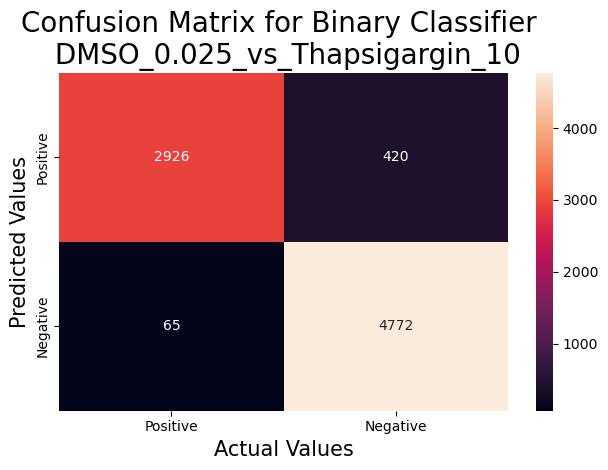

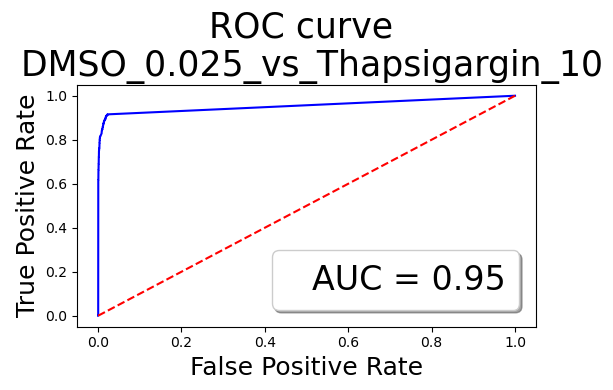

In [33]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(
        y_pred_list,
        df_values_Y,
        params,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
        title=params.MODEL_NAME,
        shuffle=SHUFFLE_DATA,
    )
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        df_values_Y,
        params,
        y_pred_prob_list,
        test_name=f"{params.MODEL_NAME}_hold_out",
        model_name=params.MODEL_NAME,
        title=params.MODEL_NAME,
        shuffle=SHUFFLE_DATA,
    )
else:
    raise Exception("Model type must be specified for proper model testing")